In [117]:
#import required libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [118]:
#import the data
df=pd.read_csv("TSLA.csv")

In [119]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


In [120]:
#check for null values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [121]:
df1=df.drop('Date', axis=1)

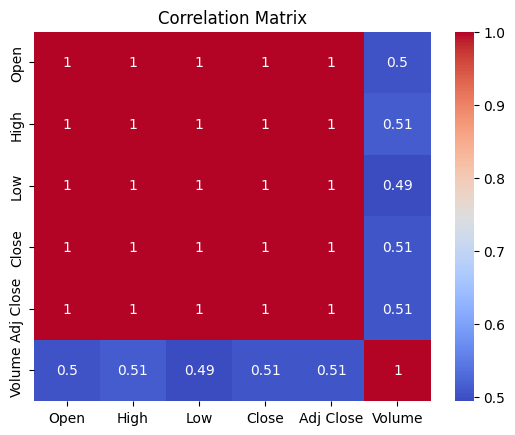

In [122]:
corr_matrix = df1.corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [123]:
# Extract the 'Close' column for prediction
data = df[['Close']].values

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [124]:
#create sequence of data 
def prepare_data(data, time_steps=1):
    X, Y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        Y.append(data[i + time_steps, 0])
    return np.array(X), np.array(Y)

time_steps = 5  # Number of previous time steps to consider
X_train, y_train = prepare_data(train_data, time_steps)
X_test, y_test = prepare_data(test_data, time_steps)

# Reshape the input data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [125]:
# Initialize and compile the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(time_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
53/53 [==============================] - 4s 6ms/step - loss: 0.1718
Epoch 2/10
53/53 [==============================] - 0s 9ms/step - loss: 0.0042
Epoch 3/10
53/53 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 4/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 5/10
53/53 [==============================] - 0s 5ms/step - loss: 0.0037
Epoch 6/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 7/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0037
Epoch 8/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 9/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 10/10
53/53 [==============================] - 0s 6ms/step - loss: 0.0036


In [126]:
# Predict using LSTM model
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions to get the actual closing prices
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test = scaler.inverse_transform([y_test])

# Flatten the predictions for plotting
#lr_predictions = lr_predictions.flatten()
lstm_predictions = lstm_predictions.flatten()
y_test = y_test.flatten()


23/23 [==============================] - 1s 3ms/step


In [127]:
#import library for computing the performance indicators
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [128]:
#R squared
r2=r2_score(y_test,lstm_predictions)
r2

0.6138118342747256

In [129]:
### Test Data RMSE
import math
math.sqrt(mean_squared_error(y_test,lstm_predictions))

38.56880585281885

In [130]:
#Mean absolute error 
mae=mean_absolute_error(y_test,lstm_predictions)
mae

24.44826052035726

In [131]:
lstm_predictions_train = lstm_model.predict(X_train)

53/53 [==============================] - 0s 3ms/step


In [132]:
lstm_predictions_train=scaler.inverse_transform(lstm_predictions_train)

In [133]:
lstm_predictions_train = np.array(lstm_predictions_train)

In [134]:
lstm_predictions_train=lstm_predictions_train.flatten()

In [135]:
train_pred=np.concatenate((lstm_predictions_train, lstm_predictions_train[-5:]))

In [136]:
train_pred

array([ 21.721582,  20.162333,  18.616602, ..., 244.22774 , 244.84312 ,
       246.36159 ], dtype=float32)

In [137]:
lstm_predictions=np.concatenate((lstm_predictions, lstm_predictions[-5:]))

In [138]:
predicted_closing_price=np.concatenate((train_pred,lstm_predictions))

In [139]:
df['predicted_closing_price']=np.hstack([predicted_closing_price])

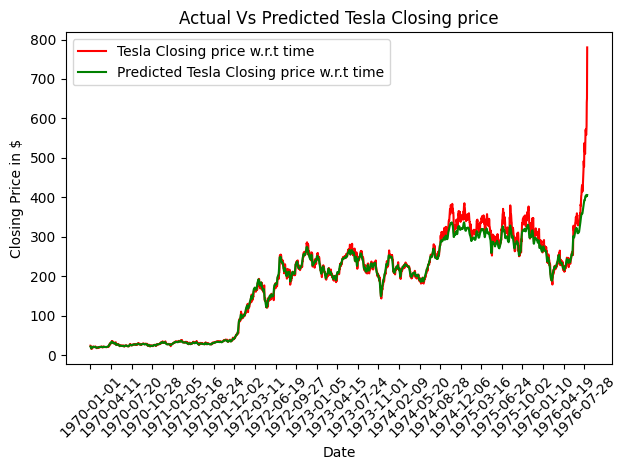

In [140]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np

# Reduce the number of displayed dates
subset_dates = df['Date'][::100]  # Display every 100th date

# Convert subset dates to indices
subset_indices = np.arange(len(df['Date']))[::100]

plt.plot(df['Date'], df['Close'], color='r', label='Tesla Closing price w.r.t time')
plt.plot(df['Date'], df['predicted_closing_price'], color='green', label='Predicted Tesla Closing price w.r.t time')

plt.title('Actual Vs Predicted Tesla Closing price')
plt.xlabel('Date')
plt.ylabel('Closing Price in $')

# Rotate the date labels
plt.xticks(rotation=45)

# Set the x-axis to display only the subset of dates
plt.gca().xaxis.set_major_locator(ticker.FixedLocator(subset_indices))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize the date format if needed

plt.legend()
plt.tight_layout()
plt.show()
